In [33]:
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    ConfusionMatrixDisplay, RocCurveDisplay,
    roc_auc_score, precision_score, recall_score, f1_score
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score


import gensim
from gensim.models import Word2Vec

In [2]:
# Downloading stopwords
nltk.download("punkt")
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
stop_words = stopwords.words("spanish")

[nltk_data] Downloading package punkt to /home/spinzon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/spinzon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/spinzon/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/spinzon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [57]:
stop_words

['de',
 'la',
 'que',
 'el',
 'en',
 'y',
 'a',
 'los',
 'del',
 'se',
 'las',
 'por',
 'un',
 'para',
 'con',
 'no',
 'una',
 'su',
 'al',
 'lo',
 'como',
 'más',
 'pero',
 'sus',
 'le',
 'ya',
 'o',
 'este',
 'sí',
 'porque',
 'esta',
 'entre',
 'cuando',
 'muy',
 'sin',
 'sobre',
 'también',
 'me',
 'hasta',
 'hay',
 'donde',
 'quien',
 'desde',
 'todo',
 'nos',
 'durante',
 'todos',
 'uno',
 'les',
 'ni',
 'contra',
 'otros',
 'ese',
 'eso',
 'ante',
 'ellos',
 'e',
 'esto',
 'mí',
 'antes',
 'algunos',
 'qué',
 'unos',
 'yo',
 'otro',
 'otras',
 'otra',
 'él',
 'tanto',
 'esa',
 'estos',
 'mucho',
 'quienes',
 'nada',
 'muchos',
 'cual',
 'poco',
 'ella',
 'estar',
 'estas',
 'algunas',
 'algo',
 'nosotros',
 'mi',
 'mis',
 'tú',
 'te',
 'ti',
 'tu',
 'tus',
 'ellas',
 'nosotras',
 'vosotros',
 'vosotras',
 'os',
 'mío',
 'mía',
 'míos',
 'mías',
 'tuyo',
 'tuya',
 'tuyos',
 'tuyas',
 'suyo',
 'suya',
 'suyos',
 'suyas',
 'nuestro',
 'nuestra',
 'nuestros',
 'nuestras',
 'vuestro'

## Carga de datos y preparación

In [37]:
train_df = pd.read_excel("./data/cat_6716.xlsx")
test_df = pd.read_excel("./data/SinEtiquetatest_cat_6716.xlsx")

In [5]:
train_df.shape

(3000, 2)

In [6]:
train_df.sample(10)

,Textos_espanol,sdg
2037,Las teorías de la aprobación del gobierno gene...,16
2520,El presente artículo analiza las particularida...,16
2821,Con la aparición en 2010 de un ensayo de Marti...,16
2301,El actual debate sobre la inmigración refleja ...,16
770,"Según la República Islámica de Irán, se está p...",6
2054,La expulsión de extranjeros es una cuestión de...,16
1954,"Pueden ser significativos, especialmente si se...",7
1056,"De hecho, la novedad de las tecnologías consid...",7
2514,La historia del trabajo social como profesión ...,16
2558,Resumen Los puertos son espacios en los que pu...,16


In [38]:
test_df.sample(10)

,Textos_espanol,sdg
124,Las definiciones modernas de los delitos incoa...,NaN
755,Esto permite a Georgia exportar 700 MW adicion...,NaN
609,Corea se ha convertido en el líder mundial en ...,NaN
547,Este capítulo examina la concepción de la paz ...,NaN
24,Esta flexibilidad significa que no todo el val...,NaN
975,Este artículo explora la historia y el impacto...,NaN
78,El vínculo histórico entre el anticolonialismo...,NaN
408,Los ministerios ambientales pueden estar inter...,NaN
446,Este artículo elabora y amplía el concepto de ...,NaN
154,IntroducciÃ³n -- Combatientes extranjeros en e...,NaN


In [7]:
train_df.dtypes

Textos_espanol    object
sdg                int64
dtype: object

In [59]:
count = train_df["sdg"].value_counts()
count

sdg
6     1000
7     1000
16    1000
Name: count, dtype: int64

In [8]:
train_df["Textos_espanol"]= train_df["Textos_espanol"].astype(str)

In [9]:
test_df = pd.read_excel("./data/SinEtiquetatest_cat_6716.xlsx")

In [10]:
test_df

,Textos_espanol,sdg
0,1. 1. Introducción: Las Estructuras del Derech...,NaN
1,Las aguas subterráneas se han debatido en el c...,NaN
2,La presente contribución evalúa la jurispruden...,NaN
3,"Sin embargo, este crédito fiscal expira en 201...",NaN
4,"Este estudio explora las actitudes, comportami...",NaN
...,...,...
975,Este artículo explora la historia y el impacto...,NaN
976,Mientras que algunos dan mayor énfasis a la ma...,NaN
977,Una innovación importante para garantizar el s...,NaN
978,El Salvador continúa luchando con niveles elev...,NaN


Los datos contienen un texto en espanol y una clasificacion de pertenencia algun grupo, debemos simplificar los textos lo mas posible sin perder su intencion para poder expresarlos de forma numerica lo mejor posible.

## Preparacion de los datos

Se pasa todo a minusculas y se eliminan signos de puntuacion y caracteres especiales para facilitar el procesamiento de las palabras

In [11]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower()
    text=text.strip()
    text=re.compile('<.*?>').sub('', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\[[0-9]*\]',' ',text)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text)
    text = re.sub(r'\s+',' ',text)
    return text


Tambien se remueven "Stop words" o palabras genericas que no afectan el sentimieno general en el texto

In [12]:
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stop_words]
    return ' '.join(a)

Se utiliza la lematizacion para reducir palabras a su estado mas basico removiendo conjugaciones

In [13]:
#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()

# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [14]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

Tomado de https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e

In [39]:
train_df['clean_text'] = train_df['Textos_espanol'].apply(lambda x: finalpreprocess(x))
test_df['clean_text'] = test_df['Textos_espanol'].apply(lambda x: finalpreprocess(x))
train_df.head()

,Textos_espanol,sdg,clean_text
0,"Es importante destacar que, en un año de sequí...",6,importante destacar año sequía espera disminuy...
1,Hay una gran cantidad de literatura sobre Aust...,6,gran cantidad literatura australia área sugier...
2,"Los procesos de descentralización, emprendidos...",6,procesos descentralización emprendidos serie a...
3,Esto puede tener consecuencias sustanciales pa...,6,puede tener consecuencias sustanciales calidad...
4,La función de beneficio también incorpora pará...,6,función beneficio incorpora parámetros afectan...


## Vectorizacion

Para que los modelos de clasificacion puedan trabajar con los datos es importante darles valores numericos primero

### Division de datos de entranamiento en entranamineto y prueba

In [16]:
X_train, X_test, y_train, y_test = train_test_split(train_df["clean_text"],train_df["sdg"],test_size=0.2,shuffle=True)

In [17]:
X_train_tok= [nltk.word_tokenize(i) for i in X_train]
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

In [18]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))
    def fit(self, X, y):
        return self
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
train_df['clean_text_tok']=[nltk.word_tokenize(i) for i in train_df['clean_text']]
model = Word2Vec(train_df['clean_text_tok'],min_count=1)
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))
modelw = MeanEmbeddingVectorizer(w2v)

In [19]:
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_test_tok)

## Modelo de regresion logistica

In [43]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression (W2v)
lr_w2v=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_w2v.fit(X_train_vectors_w2v, y_train)  #model
y_predict = lr_w2v.predict(X_train_vectors_w2v)
print('Confusion Matrix Train:',confusion_matrix(y_train, y_predict))
print(classification_report(y_train,y_predict))


#Predict y value for test dataset
y_predict = lr_w2v.predict(X_val_vectors_w2v)
y_prob = lr_w2v.predict_proba(X_val_vectors_w2v)[:,1]
print('Confusion Matrix Test:',confusion_matrix(y_test, y_predict))
print(classification_report(y_test,y_predict))
unique, counts = np.unique(y_predict, return_counts=True)
dict(zip(unique, counts))

Confusion Matrix Train: [[721  30  40]
 [ 32 710  52]
 [ 23   6 786]]
              precision    recall  f1-score   support

           6       0.93      0.91      0.92       791
           7       0.95      0.89      0.92       794
          16       0.90      0.96      0.93       815

    accuracy                           0.92      2400
   macro avg       0.93      0.92      0.92      2400
weighted avg       0.93      0.92      0.92      2400

Confusion Matrix Test: [[193   6  10]
 [ 10 187   9]
 [  7   1 177]]
              precision    recall  f1-score   support

           6       0.92      0.92      0.92       209
           7       0.96      0.91      0.94       206
          16       0.90      0.96      0.93       185

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600



{6: 210, 7: 194, 16: 196}

Vemos buenas metricas tanto en train como en test lo que sugiere que no hay problemas ni de underfitting ni de overfitting.

In [21]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label = 16)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

AUC: 0.18918918918918923


El valor del AUC no representa correctamente la calidad del modelo debido a que no se ajusta a un data set con valores no binarios, nuestro dataset tiene 3 labels por lo que su valor no se toma en cuenta.

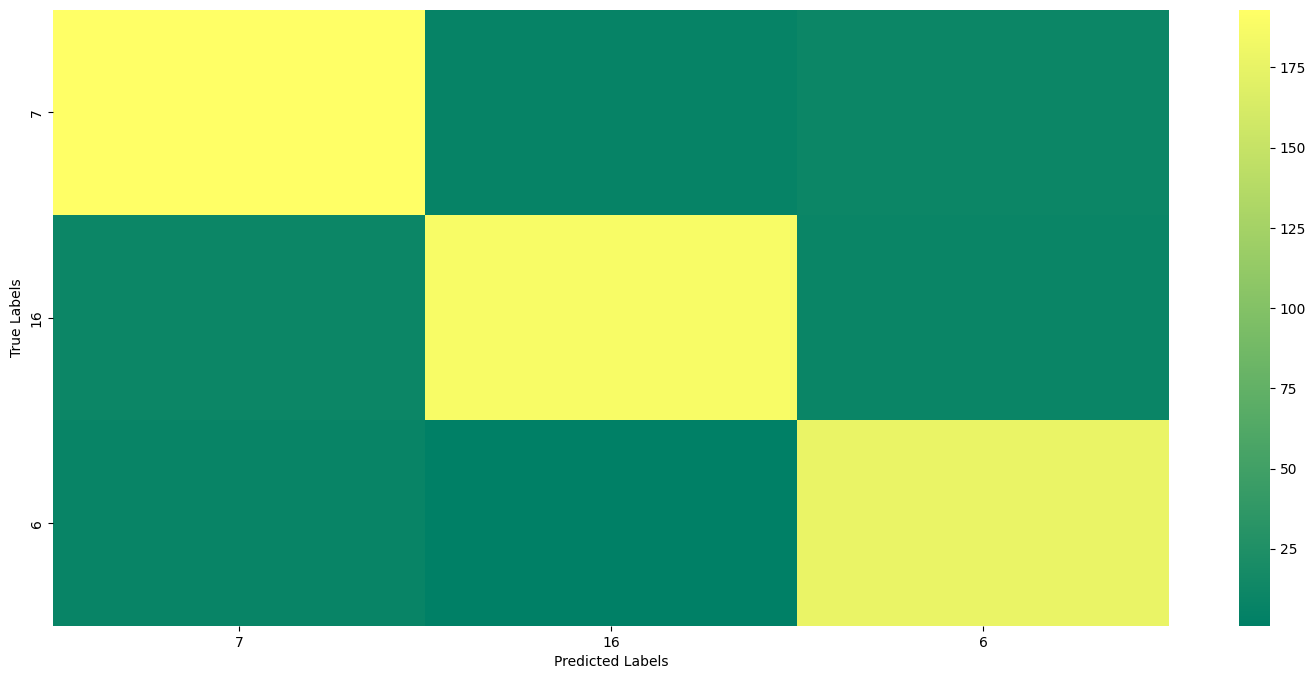

In [36]:
plt.figure(figsize = (18,8))
sns.heatmap(confusion_matrix(y_test, y_predict), annot = False, xticklabels = y_test.unique(), yticklabels = y_test.unique(), cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Modelo Random Forest

In [50]:
# Fitting the model using Random Forest (W2v)
Rf = RandomForestClassifier(random_state=3)
Rf.fit(X_train_vectors_w2v, y_train)
#predict y value for test dataset
predictions_rm = Rf.predict(X_val_vectors_w2v)
pred_prob = Rf.predict_proba(X_val_vectors_w2v)[:,1]
print(classification_report(y_test,predictions_rm))
print('Confusion Matrix:',confusion_matrix(y_test, predictions_rm))

              precision    recall  f1-score   support

           6       0.92      0.91      0.92       209
           7       0.93      0.92      0.92       206
          16       0.95      0.96      0.96       185

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600

Confusion Matrix: [[191  12   6]
 [ 13 190   3]
 [  4   3 178]]


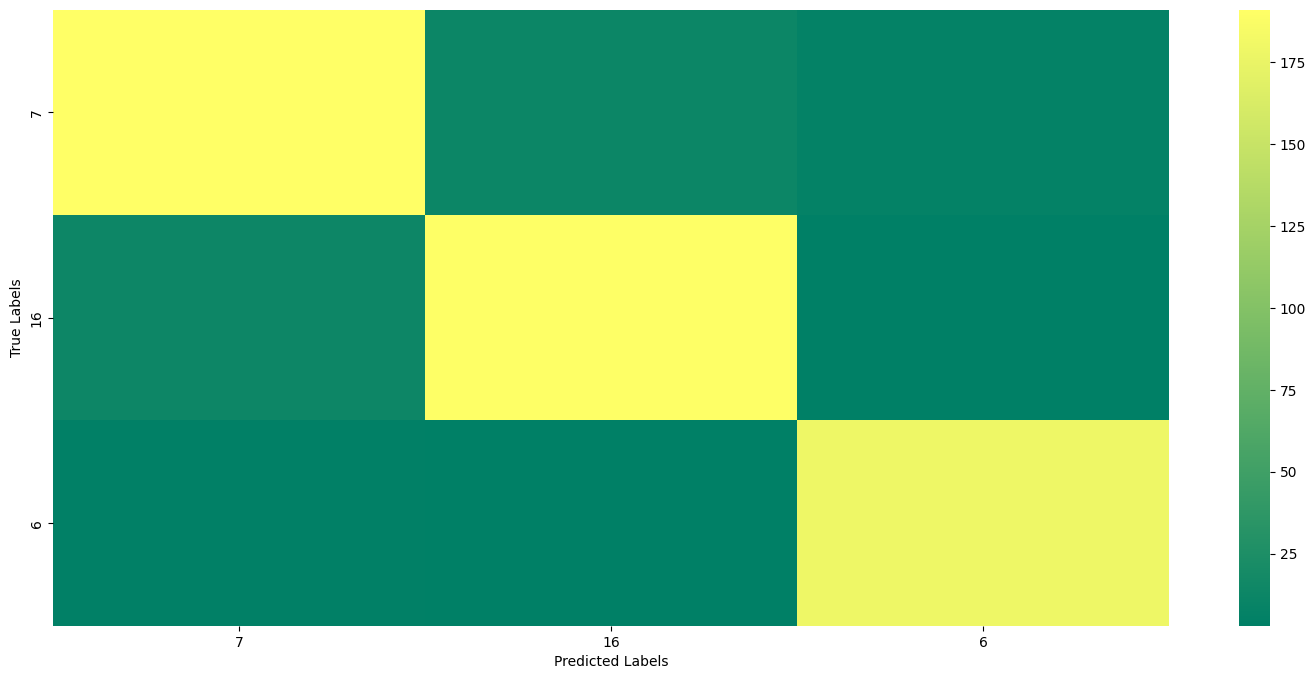

In [51]:
plt.figure(figsize = (18,8))
sns.heatmap(confusion_matrix(y_test, predictions_rm), annot = False, xticklabels = y_test.unique(), yticklabels = y_test.unique(), cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Modelo del Arboles de decision

In [52]:
tfidf_model = DecisionTreeClassifier(random_state = 1)
tfidf_model.fit(X_train_vectors_w2v, y_train)
predictions = tfidf_model.predict(X_val_vectors_w2v)
pred_prob = tfidf_model.predict_proba(X_val_vectors_w2v)[:,1]
print(classification_report(y_test,predictions))
print('Confusion Matrix:',confusion_matrix(y_test, predictions))


              precision    recall  f1-score   support

           6       0.84      0.85      0.85       209
           7       0.83      0.85      0.84       206
          16       0.94      0.90      0.92       185

    accuracy                           0.87       600
   macro avg       0.87      0.87      0.87       600
weighted avg       0.87      0.87      0.87       600

Confusion Matrix: [[178  26   5]
 [ 25 175   6]
 [  9   9 167]]


Notamos que los resultados del algoritmo de random forest son mejores que al utilizar el algoritmo de arboles de decision y tiene un rendimiento similar al que obtuvimos al usar el de Logistic Regression , con algunas mejoras minimas en el F1-score

In [53]:
estimators = Rf.estimators_
print("Number of trees:", len(estimators))
print("Trees depth (mean):", np.mean([tree.get_depth() for tree in estimators]))

Number of trees: 100
Trees depth (mean): 14.69


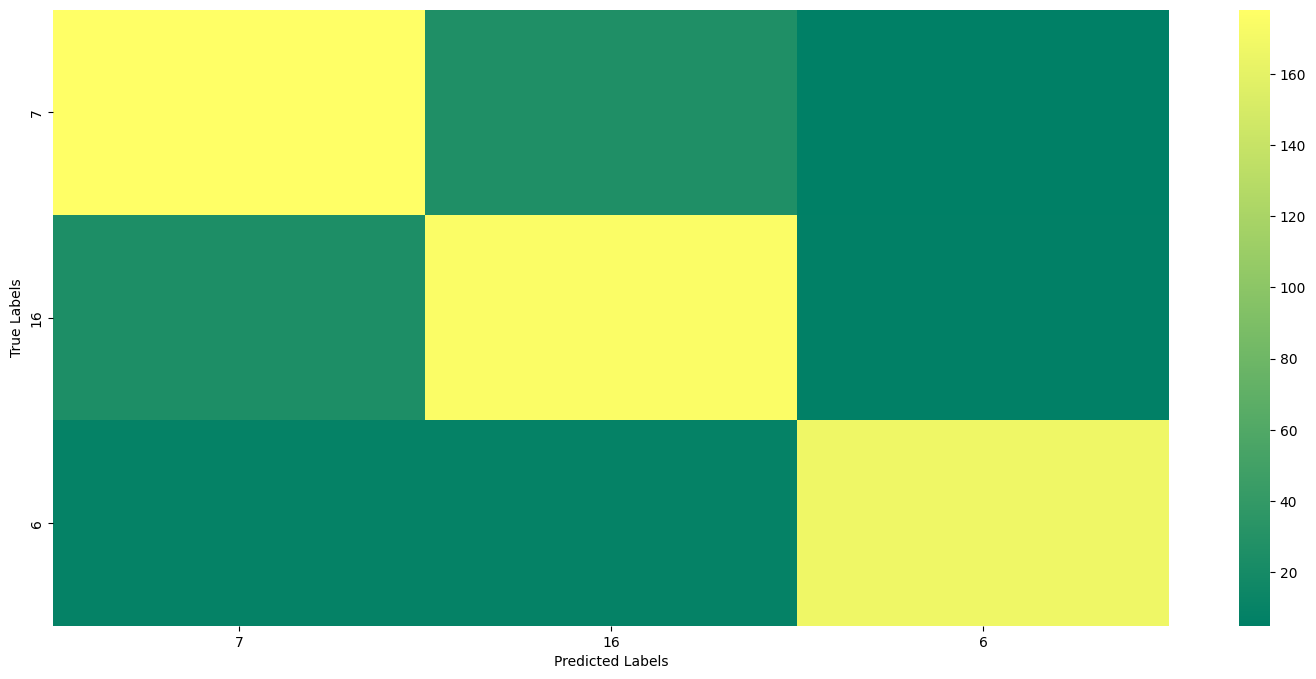

In [54]:
plt.figure(figsize = (18,8))
sns.heatmap(confusion_matrix(y_test, predictions), annot = False, xticklabels = y_test.unique(), yticklabels = y_test.unique(), cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Clasificacion de los datos finales

In [62]:
X_tok= [nltk.word_tokenize(i) for i in test_df["clean_text"]]
X_vectors_w2v = modelw.transform(X_tok)
predictions = tfidf_model.predict(X_vectors_w2v)
test_df["sdg"] = predictions

In [63]:
test_df.head(10)

,Textos_espanol,sdg,clean_text
0,1. 1. Introducción: Las Estructuras del Derech...,16,introducción estructuras derecho penal estánda...
1,Las aguas subterráneas se han debatido en el c...,6,aguas subterráneas debatido contexto tarificac...
2,La presente contribución evalúa la jurispruden...,16,presente contribución evalúa jurisprudencia tr...
3,"Sin embargo, este crédito fiscal expira en 201...",7,embargo crédito fiscal expira wemau calcula qu...
4,"Este estudio explora las actitudes, comportami...",16,estudio explora actitudes comportamientos perc...
5,Desde los tratados de paz de Westfalia de 1648...,16,tratados paz westfalia carta naciones unidas d...
6,La existencia o creación de vínculos entre los...,16,existencia creación vínculos ámbitos políticos...
7,La seguridad marítima es una de las principale...,16,seguridad marítima principales preocupaciones ...
8,El Derecho Penal Internacional [DPI] contiene ...,16,derecho penal internacional dpi contiene serie...
9,El proyecto de gasoducto pretende establecer a...,7,proyecto gasoducto pretende establecer acuerdo...


In [64]:
test_df.to_csv("resultados.csv", index=False)